# Impact data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.datasources import impact, codab, floodscan, worldpop
from src.constants import AOI_ADM2_PCODES, AOI_ADM1_PCODES

In [3]:
adm2_pop = worldpop.load_adm2_worldpop()

In [4]:
adm2 = codab.load_codab(admin_level=2)
adm2_aoi = adm2[adm2["ADM1_PCODE"].isin(AOI_ADM1_PCODES)]
adm1 = codab.load_codab(admin_level=1)
adm1_aoi = adm1[adm1["ADM1_PCODE"].isin(AOI_ADM1_PCODES)]

In [5]:
nema = pd.read_excel(
    impact.NEMA_RAW_IMPACT_PATH, sheet_name="2022 NEMA Flood Data"
)
nema = nema[nema["STATE"].isin(["Borno", "Adamawa", "Yobe"])]
# all the LGA names match, fortunately
nema = nema.merge(
    adm2_aoi[["ADM2_PCODE", "ADM2_EN"]], right_on="ADM2_EN", left_on="LGA"
).drop(columns=["LGA"])
nema_sum = (
    nema.groupby(["ADM2_PCODE", "ADM2_EN"])["PERSONS AFFECTED"]
    .sum()
    .astype(int)
    .reset_index()
    .rename(columns={"PERSONS AFFECTED": "total_affected"})
)
nema_sum

,ADM2_PCODE,ADM2_EN,total_affected
0,NG002001,Demsa,12996
1,NG002002,Fufore,11669
2,NG002005,Girei,2731
3,NG002010,Madagali,16831
4,NG002016,Numan,12598
5,NG002017,Shelleng,9549
6,NG002018,Song,9617
7,NG002020,Yola North,11825
8,NG002021,Yola South,11888
9,NG008005,Biu,312


In [6]:
filename = (
    "2022-flood-affected-areas-2022-by-lgas-as-of-30th-october-2022-3.csv"
)
actual = pd.read_csv(impact.RAW_IMPACT_DIR / filename)
actual = actual.merge(
    adm2[["ADM2_PCODE", "ADM2_EN", "ADM1_PCODE", "ADM1_EN"]],
    right_on="ADM2_EN",
    left_on="LGA",
).drop(columns=["LGA", "State"])
actual

,Population Potentially Affected,ADM2_PCODE,ADM2_EN,ADM1_PCODE,ADM1_EN
0,21626,NG002001,Demsa,NG002,Adamawa
1,73532,NG002002,Fufore,NG002,Adamawa
2,74,NG002003,Ganye,NG002,Adamawa
3,66278,NG002005,Girei,NG002,Adamawa
4,647,NG002004,Gombi,NG002,Adamawa
...,...,...,...,...,...
60,18595,NG036013,Nguru,NG036,Yobe
61,0,NG036014,Potiskum,NG036,Yobe
62,4298,NG036015,Tarmua,NG036,Yobe
63,21675,NG036016,Yunusari,NG036,Yobe


In [7]:
fs = floodscan.load_adm2_flood_exposures()
fs = fs[(fs["year"] == 2022) & fs["ADM2_PCODE"].isin(AOI_ADM2_PCODES)].drop(
    columns="year"
)
fs = fs.merge(nema_sum, on="ADM2_PCODE", how="left")
fs["total_affected"] = fs["total_affected"].fillna(0).astype(int)
fs = fs.merge(adm2_pop, on="ADM2_PCODE")
# fs = fs.rename(columns={"Population Potentially Affected": "total_impacted"})
fs["error"] = fs["total_exposed"] - fs["total_affected"]
fs["frac_exposed"] = fs["total_exposed"] / fs["total_pop"]
fs["geo_error"] = fs["total_exposed"] / fs["total_affected"]
fs["frac_error"] = fs["error"] / fs["total_pop"]
fs["frac_affected"] = fs["total_affected"] / fs["total_pop"]

In [8]:
fs

,total_exposed,ADM2_PCODE,ADM2_EN,total_affected,total_pop,error,frac_exposed,geo_error,frac_error,frac_affected
0,28515,NG008001,NaN,0,150414.19,28515,0.189577,inf,0.189577,0.000000
1,21758,NG008002,NaN,0,173069.62,21758,0.125718,inf,0.125718,0.000000
2,81210,NG036001,Bade,1523,230216.22,79687,0.352755,53.322390,0.346140,0.006616
3,2453,NG008003,NaN,0,439682.30,2453,0.005579,inf,0.005579,0.000000
4,3253,NG008004,NaN,0,125018.90,3253,0.026020,inf,0.026020,0.000000
...,...,...,...,...,...,...,...,...,...,...
60,4591,NG002019,NaN,0,87333.14,4591,0.052569,inf,0.052569,0.000000
61,69155,NG002020,Yola North,11825,234307.00,57330,0.295147,5.848203,0.244679,0.050468
62,83592,NG002021,Yola South,11888,384152.84,71704,0.217601,7.031629,0.186655,0.030946
63,11041,NG036016,Yunusari,47,188521.81,10994,0.058566,234.914894,0.058317,0.000249


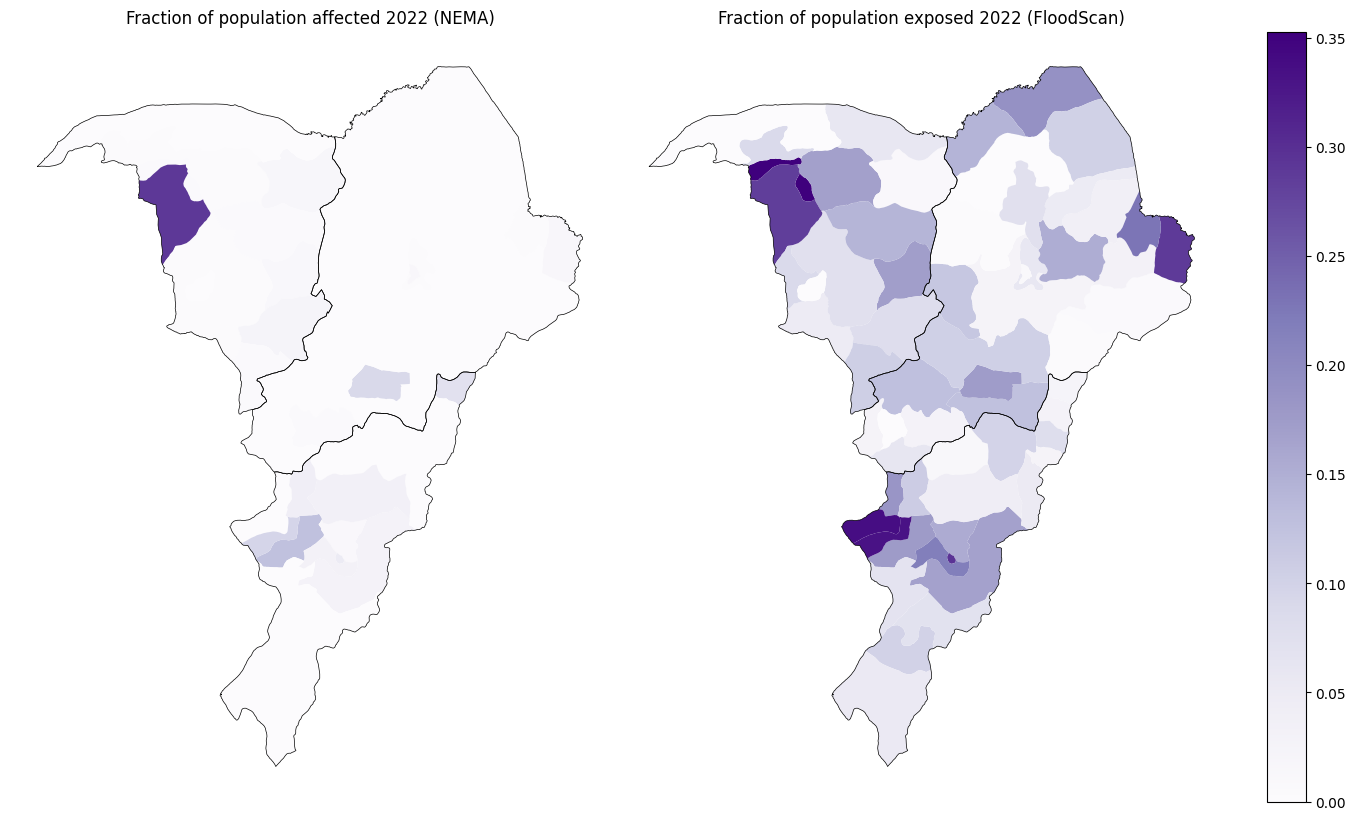

In [9]:
fs_plot = adm2.merge(fs, on="ADM2_PCODE")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

vmax = fs_plot[["frac_affected", "frac_exposed"]].max().max()

axs[0].set_title("Fraction of population affected 2022 (NEMA)")
fs_plot.plot(
    column="frac_affected",
    ax=axs[0],
    cmap="Purples",
    vmin=0,
    vmax=vmax,
)

axs[1].set_title("Fraction of population exposed 2022 (FloodScan)")
fs_plot.plot(
    column="frac_exposed",
    ax=axs[1],
    cmap="Purples",
    legend=True,
    vmin=0,
    vmax=vmax,
)


for ax in axs:
    adm1_aoi.boundary.plot(ax=ax, linewidth=0.5, color="k")
    ax.axis("off")

plt.subplots_adjust(wspace=-0.3)

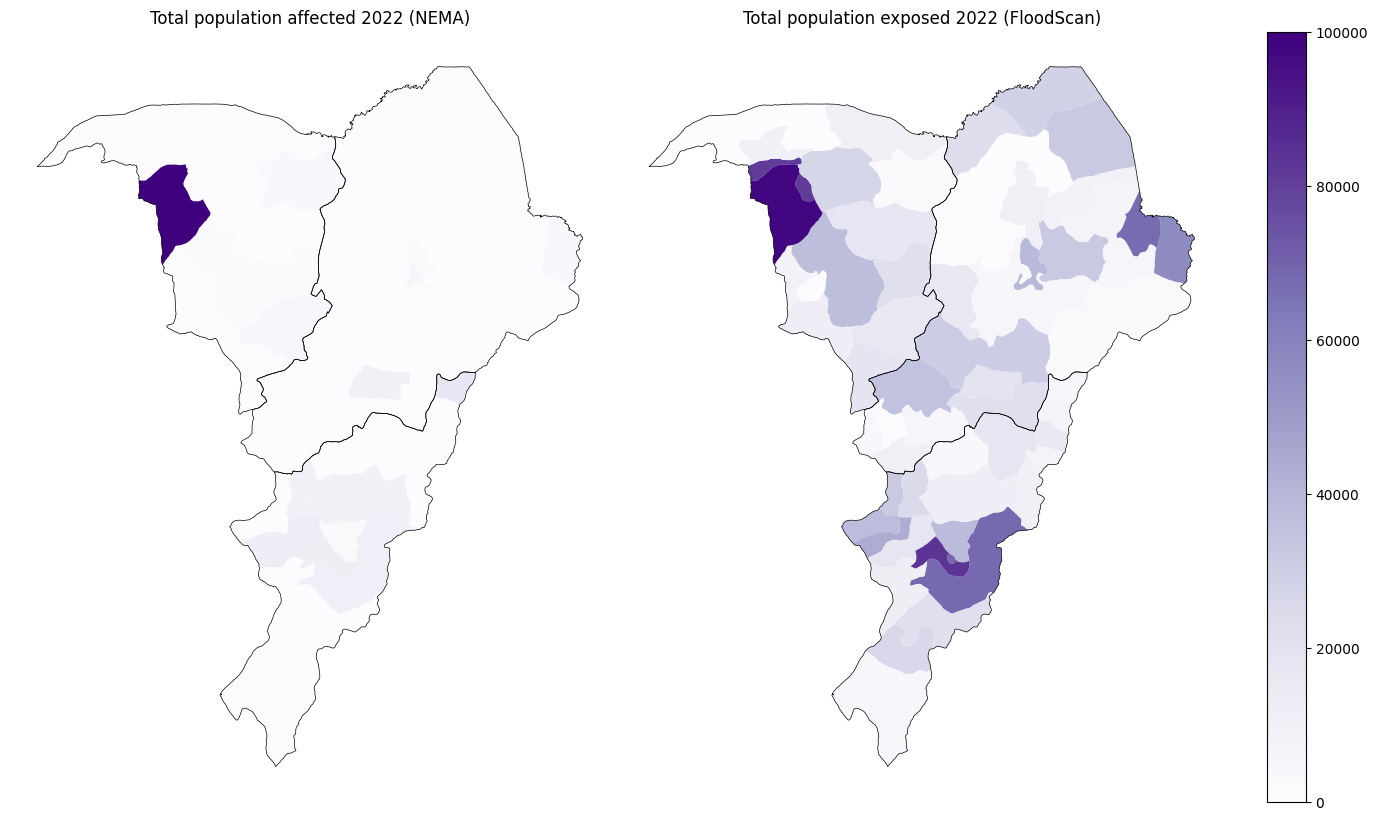

In [10]:
fs_plot = adm2.merge(fs, on="ADM2_PCODE")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

vmax = fs_plot[["total_affected", "total_exposed"]].max().max()

axs[0].set_title("Total population affected 2022 (NEMA)")
fs_plot.plot(
    column="total_affected",
    ax=axs[0],
    cmap="Purples",
    legend=False,
    vmin=0,
    vmax=vmax,
)

axs[1].set_title("Total population exposed 2022 (FloodScan)")
fs_plot.plot(
    column="total_exposed",
    ax=axs[1],
    cmap="Purples",
    legend=True,
    vmin=0,
    vmax=vmax,
)

for ax in axs:
    adm1_aoi.boundary.plot(ax=ax, linewidth=0.5, color="k")
    ax.axis("off")

plt.subplots_adjust(wspace=-0.3)